In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch
torch.cuda.is_available()

True

In [29]:
!pip install -U albumentations

  Obtaining dependency information for albumentations from https://files.pythonhosted.org/packages/9b/f6/c486cedb4f75147232f32ec4c97026714cfef7c7e247a1f0427bc5489f66/albumentations-1.3.1-py3-none-any.whl.metadata
  Using cached albumentations-1.3.1-py3-none-any.whl.metadata (34 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Obtaining dependency information for opencv-python-headless>=4.1.1 from https://files.pythonhosted.org/packages/70/78/7a13730745684584db53e8aa3c3bd84beef2dcb32bebf627bda0d6df461e/opencv_python_headless-4.8.0.76-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python_headless-4.8.0.76-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached albumentations-1.3.1-py3-none-any.whl (125 kB)
Using cached opencv_python_headless-4.8.0.76-cp37-abi3-win_amd64.whl (38.0 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\User\\Petr\\Anaconda\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.



In [40]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchvision import io, utils
from torchvision.io import read_image
from torchvision import datapoints as dp
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from PIL import Image

from xml.etree import ElementTree as ET
import pandas as pd

from torchsummary import summary

#import albumentations as A

#import torch.multiprocessing
#torch.multiprocessing.set_sharing_strategy('file_system')

In [38]:
def PASCAL_to_FasterRCNN(xml_file):
  root = ET.parse(xml_file).getroot()

  annotation_dicts = []

  for node in root:
    if node.tag == 'filename':
      #path_img = dir_path + node.text
      path_img = node.text

    if node.tag == 'object':
      dict_to_add = {}
      dict_to_add['filepath'] = path_img
      for obj_node in node:
        if obj_node.tag == 'bndbox':
          for crs in obj_node:
            dict_to_add[crs.tag] = int(crs.text) - 1 # Note that indexing for pixel values starts at 0 (https://github.com/cwu392/Faster_RCNN?ysclid=lm03zqxxih575518541)
      for obj_node in node:
        if obj_node.tag == 'name':
          dict_to_add['class'] = obj_node.text
      annotation_dicts.append(dict_to_add)

  return annotation_dicts


In [39]:
def xml_to_csv(dir_path):
  data_list = []
  for file in os.listdir(dir_path):
    if file.endswith('.xml'):
      data = PASCAL_to_FasterRCNN(dir_path + file)
      data_list.extend(data)

  df = pd.DataFrame(data=data_list)
  df.to_csv(dir_path + 'annotations.csv', header=True, index=False)

In [31]:
annotations_path = './Annotations/'
xml_to_csv(dir_path=annotations_path)

In [32]:
df = pd.read_csv(annotations_path + 'annotations.csv')

pths = list(df['filepath'].unique())

im_lst = list(sorted(os.listdir('./Images')))

print(len(pths), len(im_lst))

for im in im_lst:
    if im not in pths:
        print(im)
    

953 953


In [62]:
root = './'

class OrthomasaicDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'Images'))))

        #load cvs file with annotations
        self.BBxs = root + 'Annotations/annotations.csv'

    def __getitem__(self, idx):
        # load images
        img_path = os.path.join(self.root, 'Images', self.imgs[idx])
        #get image as PIL Image (ToTensor transform converts PIL to tensor and scale values to [0, 1])
        img = Image.open(img_path).convert('RGB')

        # get bounding boxes coordinates
        df = pd.read_csv(self.BBxs)
        df = df[df['filepath'] == self.imgs[idx]]

        boxes = []
        num_objs = 0
        for row in df.itertuples():
          num_objs += 1
          boxes.append([row.xmin, row.ymin, row.xmax, row.ymax])

        boxes = torch.Tensor(boxes)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = torch.as_tensor([idx], dtype=torch.int64)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision datapoints:
 #       img = dp.Image(img)

        target = {}
        target["boxes"] = dp.BoundingBox(boxes, format="XYXY", spatial_size=F.get_spatial_size_image_pil(img)[::-1])
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
          img, target = self.transforms(img, target)
#            sample = self.transforms(image = np.asarray(img),
#                                     bboxes = target['boxes'],
#                                     labels = labels)
#            img, target['boxes'] = sample['image'], torch.Tensor(sample['bboxes'])

        return img, target

    def __len__(self):
        return len(self.imgs)

In [21]:
#%%shell
%%system
# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

SyntaxError: invalid syntax (1348586645.py, line 5)

In [186]:
#from engine import train_one_epoch, evaluate
#import utils
#import transforms as T
#from transforms import RandomHorizontalFlip, RandomGrayscale, ToTensor, Compose
#import my_transforms as MyT

def get_transform(train):
    transforms = []

    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
#        transforms.append(v2.RandomCrop([1500, 1500]))
#        transforms.append(v2.RandomHorizontalFlip(p=0.5))
#        transforms.append(v2.RandomVerticalFlip(p=0.5))
#        transforms.append(v2.RandomAffine(degrees=30))
#        transforms.append(v2.RandomRotation(degrees=90))
#        transforms.append(v2.ColorJitter())
#        transforms.append(T.RandomGrayscale(0.5))
#        transforms.append(T.RandomRotation(degrees=45))
        transforms.append(v2.RandomChoice([
            v2.RandomCrop([1500, 1500]),
#            v2.RandomRotation(degrees=90),
#            v2.RandomAffine(degrees=30),
            v2.RandomHorizontalFlip(p=0.5),
            ], p=[0.5, 0.5]))
        transforms.append(v2.RandomChoice([
#            v2.RandomCrop([1500, 1500]),
            v2.RandomRotation(degrees=90),
            v2.CenterCrop(size=3000),
#            v2.RandomHorizontalFlip(p=0.5),
            ], p=[0.5, 0.5]))
        transforms.append(v2.RandomChoice([
            v2.ColorJitter(),
            v2.RandomPhotometricDistort()
            ], p=[0.5, 0.5]))
        transforms.append(v2.RandomGrayscale())
    transforms.append(v2.ToImageTensor())
    transforms.append(v2.ConvertImageDtype(torch.float32))
    return v2.Compose(transforms)

In [180]:
from albumentations.pytorch import ToTensorV2

def get_transform_A(train):
    transforms = []
    transforms.append(ToTensorV2(p=1.0))
    
    if train:
#        transforms.append(A.HorizontalFlip(p=1.0))
        transforms.append(A.RandomRotate90(p=1.0))
#        transforms.append(A.Blur(blur_limit=3, p=0.5))
#        transforms.append(A.ToGray(p=0.5))
    
    return A.Compose(transforms, 
        bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']})

def get_train_transform():
    return A.Compose([
    A.HorizontalFlip,
    A.RandomRotate90,
    A.Blur(blur_limit=3, p=0.1),
    A.ToGray,
    ToTensorV2(p=1.0)],
    bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']})

<class 'torchvision.datapoints._image.Image'> torch.float32 [0.0, 0.9960784912109375]


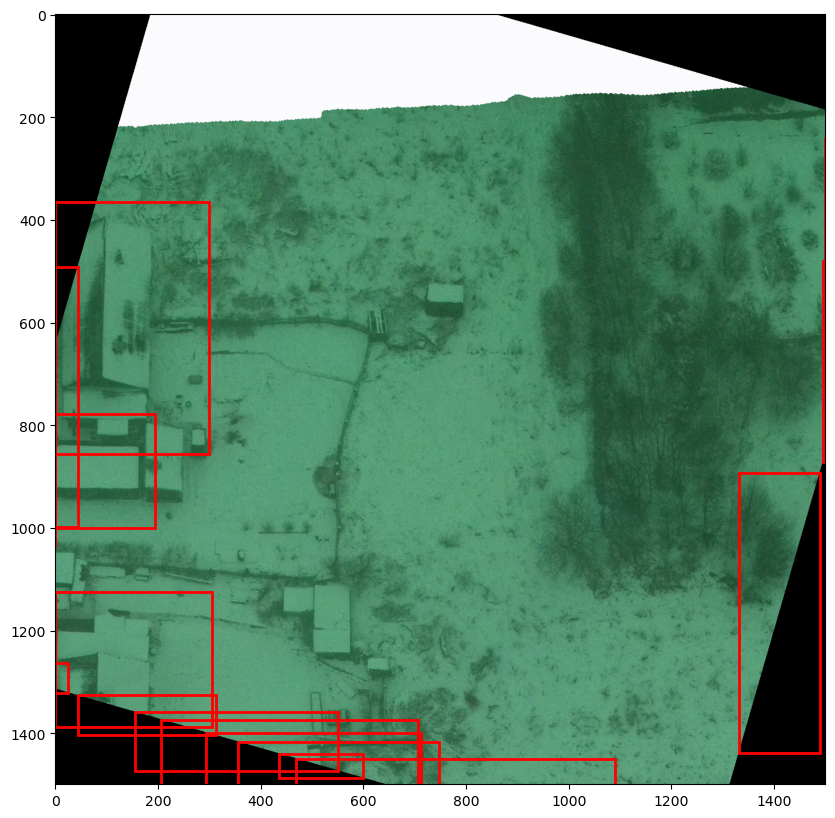

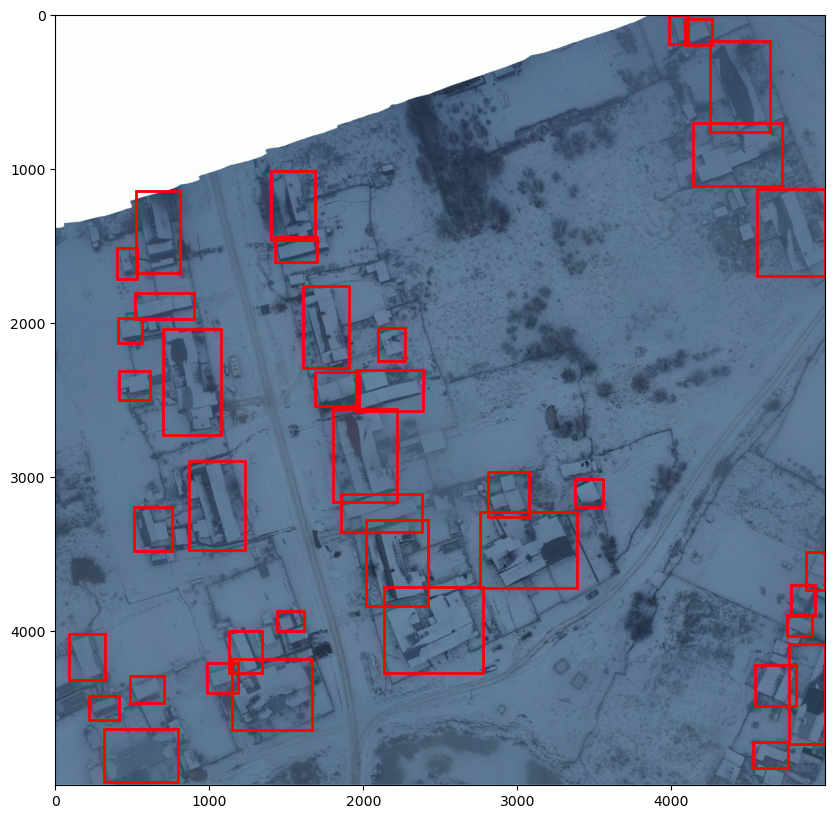

In [185]:
import utils

dataset = OrthomasaicDataset(root=root, transforms=get_transform(train=True))
dataset_test = OrthomasaicDataset(root=root, transforms=get_transform(train=False))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

imgs, targets = next(iter(data_loader))

image, target = imgs[0], targets[0]
#indx = 51

#image, target = dataset[indx]

print(type(image), image.dtype, f'[{image.min()}, {image.max()}]')

#print(target['boxes'])

#image = torch.as_tensor(image / 255, dtype=torch.float32)

#print(type(image), image.dtype)

#print(image)

#print(target)

plot_img_bbox(image.permute(1, 2, 0), target, 10)

#print(dataset.imgs[target['image_id']])

original_image, original_target = dataset_test.__getitem__(target['image_id'])

plot_img_bbox(original_image.permute(1, 2, 0), original_target, 10)

#original_image = cv2.imread(os.path.join(root, 'Images', dataset.imgs[target['image_id']]))
#original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)


#original_image = F.pil_to_tensor(original_image)
#original_image = (255.0 * (original_image - original_image.min()) / (original_image.max() - original_image.min())).to(torch.uint8)
#original_image = original_image[:3, ...]
#f, ax = plt.subplots(figsize=(7, 7))

#ax.imshow(original_image)

Input: <class 'numpy.ndarray'> image of (1500, 1500, 3) shape with uint8 data
Output: <class 'torch.Tensor'> image of torch.Size([3, 1500, 1500]) shape with torch.uint8 data


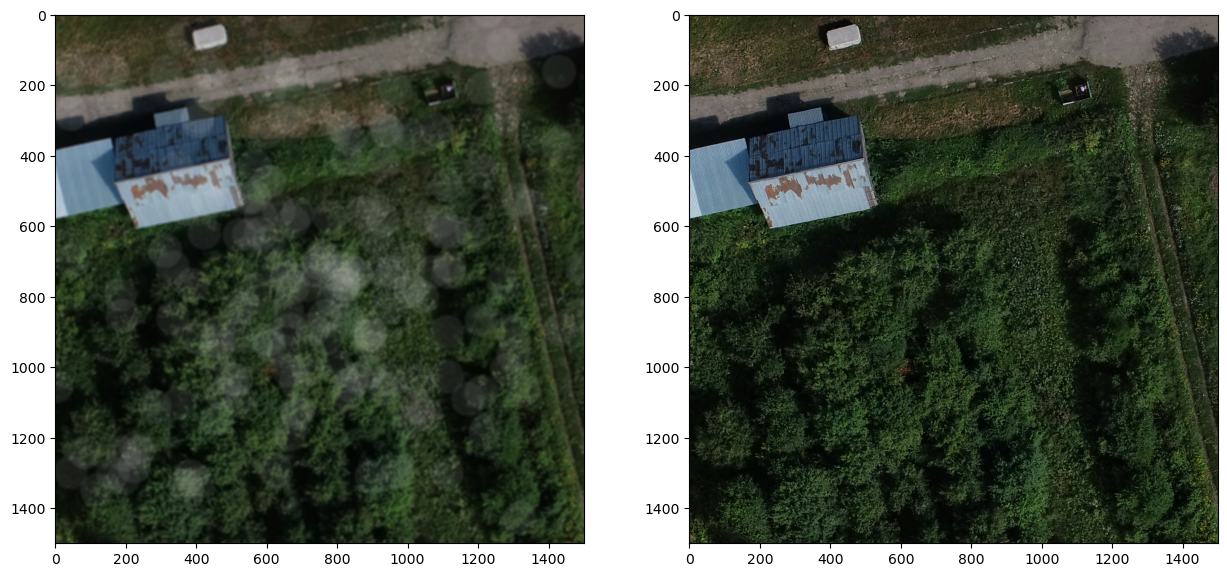

In [246]:
transform = A.Compose([
    A.RandomCrop(width=1000, height=1000, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomSnow(0.5, 0.9, 5, p=0.1),
    A.RandomFog(0.1, 0.2, 0.4, p=1.0),
    ToTensorV2(p=1.0)
])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("Images/backchar-6-38.tif")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#image = Image.open("Images/backchar-6-33.tif").convert('RGB')

#image = np.asarray(image)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

print(f'Input: {type(image)} image of {image.shape} shape with {image.dtype} data\nOutput: {type(transformed_image)} image of {transformed_image.shape} shape with {transformed_image.dtype} data')

fig, a = plt.subplots(1,2, figsize=(15, 15))

a[0].imshow(transformed_image.permute(1, 2, 0))
a[1].imshow(image)



In [133]:
import utils

dataset = OrthomasaicDataset(root=root, transforms=get_train_transform())
#data_loader = torch.utils.data.DataLoader(
#    dataset, batch_size=1, shuffle=True, num_workers=0,
#    collate_fn=utils.collate_fn)

#imgs, targets = next(iter(data_loader))

image, target = dataset[4]

print(target)

#image = torch_to_pil(imgs[0])
#image = F.pil_to_tensor(image)
#image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
#image = image[:3, ...]
#output_image = draw_bounding_boxes(image, targets[0]['boxes'], targets[0]['labels'], colors="red", width=5, font_size=90, font='TimesNewRomanRegular.ttf')
plot_img_bbox(imgs[0].permute(1, 2, 0), targets[0])

print(dataset.imgs[targets[0]['image_id']])
original_image = Image.open('./Images/' + dataset.imgs[targets[0]['image_id']])

original_image = F.pil_to_tensor(original_image)
original_image = (255.0 * (original_image - original_image.min()) / (original_image.max() - original_image.min())).to(torch.uint8)
original_image = original_image[:3, ...]

f, ax = plt.subplots(figsize=(7, 7))

ax.imshow(original_image.permute(1, 2, 0))

TypeError: BasicTransform.__init__() got an unexpected keyword argument 'image'

In [51]:
dataset.imgs[834]

'backchar-49-40.tif'

In [ ]:
dataset = OrthomasaicDataset(root, get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)
# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
print(images)
print(targets)

In [6]:
def get_object_detection_model(num_classes, pretrain=True):
    import torchvision
    from torchvision.models.detection import FasterRCNN
    from torchvision.models.detection.rpn import AnchorGenerator
    # load a model pre-trained pre-trained on COCO
    if pretrain:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT', min_size=1500, max_size=2000)
    else:
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [7]:
def apply_nms(orig_prediction, iou_thresh=0.3):

    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def torch_to_pil(img):
    return torchvision.transforms.ToPILImage()(img).convert('RGB')

In [ ]:


#img = Image.open('/content/drive/MyDrive/Net_1_images/tile_test-7-26.jpg')


images, targets = next(iter(dataloader))
model.eval()
with torch.no_grad():
  predictions = model([images[0]])

nms_predictions = apply_nms(predictions[0], iou_thresh=0.1)
nms_predictions

In [78]:
def plot_img_bbox(img, target, size):
    import matplotlib.patches as patches
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(size, size)
    a.imshow(img)
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

In [8]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [247]:
# TODO: Train with first dataset and change min and max sizes

from engine import train_one_epoch, evaluate
import utils

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = OrthomasaicDataset(root=root, transforms=get_transform(train=True))
dataset_test = OrthomasaicDataset(root=root, transforms=get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
thirty_pc = int(len(dataset) * 0.33)
dataset = torch.utils.data.Subset(dataset, indices[:-thirty_pc])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-thirty_pc:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_object_detection_model(num_classes, pretrain=True)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)


### VERY BAD LOSSES
#optimizer = torch.optim.Adam(
#    params,
#    lr=0.005,
#    momentum=0.9,
#    weight_decay=0.0005
#)


# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

cuda
Epoch: [0]  [  0/320]  eta: 0:05:29  lr: 0.000021  loss: 0.8132 (0.8132)  loss_classifier: 0.5491 (0.5491)  loss_box_reg: 0.2079 (0.2079)  loss_objectness: 0.0451 (0.0451)  loss_rpn_box_reg: 0.0112 (0.0112)  time: 1.0286  data: 0.2935  max mem: 6147
Epoch: [0]  [ 10/320]  eta: 0:03:42  lr: 0.000177  loss: 0.8132 (0.8021)  loss_classifier: 0.5066 (0.4774)  loss_box_reg: 0.2699 (0.2784)  loss_objectness: 0.0229 (0.0275)  loss_rpn_box_reg: 0.0110 (0.0189)  time: 0.7163  data: 0.2742  max mem: 6147
Epoch: [0]  [ 20/320]  eta: 0:03:31  lr: 0.000334  loss: 0.6648 (0.7001)  loss_classifier: 0.3503 (0.3824)  loss_box_reg: 0.2699 (0.2790)  loss_objectness: 0.0119 (0.0232)  loss_rpn_box_reg: 0.0091 (0.0155)  time: 0.6881  data: 0.2743  max mem: 6147
Epoch: [0]  [ 30/320]  eta: 0:03:23  lr: 0.000490  loss: 0.5290 (0.6280)  loss_classifier: 0.2304 (0.3231)  loss_box_reg: 0.2511 (0.2677)  loss_objectness: 0.0098 (0.0196)  loss_rpn_box_reg: 0.0078 (0.0175)  time: 0.6914  data: 0.2786  max mem: 

In [9]:
def cut_score(predictions: dict, score_thresh = 0.5):
    cut_index = None
    for indx, score in enumerate(predictions['scores']):
        if score < score_thresh:
            cut_index = indx
            break
    if not cut_index:
        cut_index = len(predictions['scores']) - 1
    new_pred = {}

    new_pred['boxes'] = pred['boxes'][:cut_index]
    new_pred['labels'] = pred['labels'][:cut_index]
    new_pred['scores'] = pred['scores'][:cut_index]

    return new_pred

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_object_detection_model(num_classes=2, pretrain=False)

model.load_state_dict(torch.load('model_weights.pth'))

model.to(device);

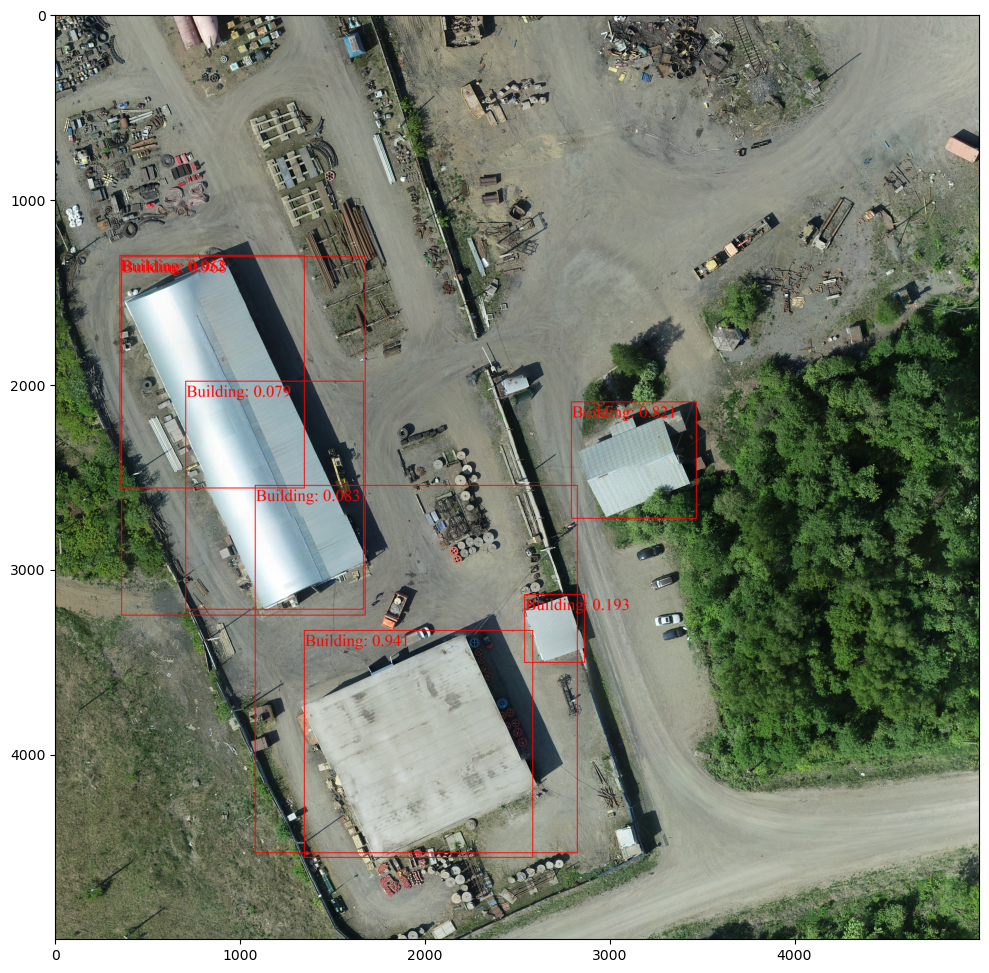

In [26]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
im_path_kedr = 'C:/Users/User/Desktop/Teobox_Kedrovka_2023-06-06T11.31.53/kedr-2-4.tif'
im_path_snow = 'C:/Users/User/Petr/Net_1/Images/Mar-1-10.tif'
im_path_test = 'C:/Users/User/Petr/Net_1/to_test_model/ship2-4-5.jpg'
image = Image.open(im_path_kedr)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x, _ = eval_transform(image, _)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    #x = x.to(device)
    predictions = model([x, ])
    pred = predictions[0]
#    pred = cut_score(predictions=pred, score_thresh=0.5)

image = F.pil_to_tensor(image)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"Building: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red", width=5, font_size=90, font='TimesNewRomanRegular.ttf')


f, ax = plt.subplots(figsize=(12, 12))

ax.imshow(output_image.permute(1, 2, 0))
f.savefig('test.jpg', bbox_inches='tight')

In [122]:
pred

{'boxes': tensor([], device='cuda:0', size=(0, 4)),
 'labels': tensor([], device='cuda:0', dtype=torch.int64),
 'scores': tensor([], device='cuda:0')}

In [27]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(1500,), max_size=2000, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU

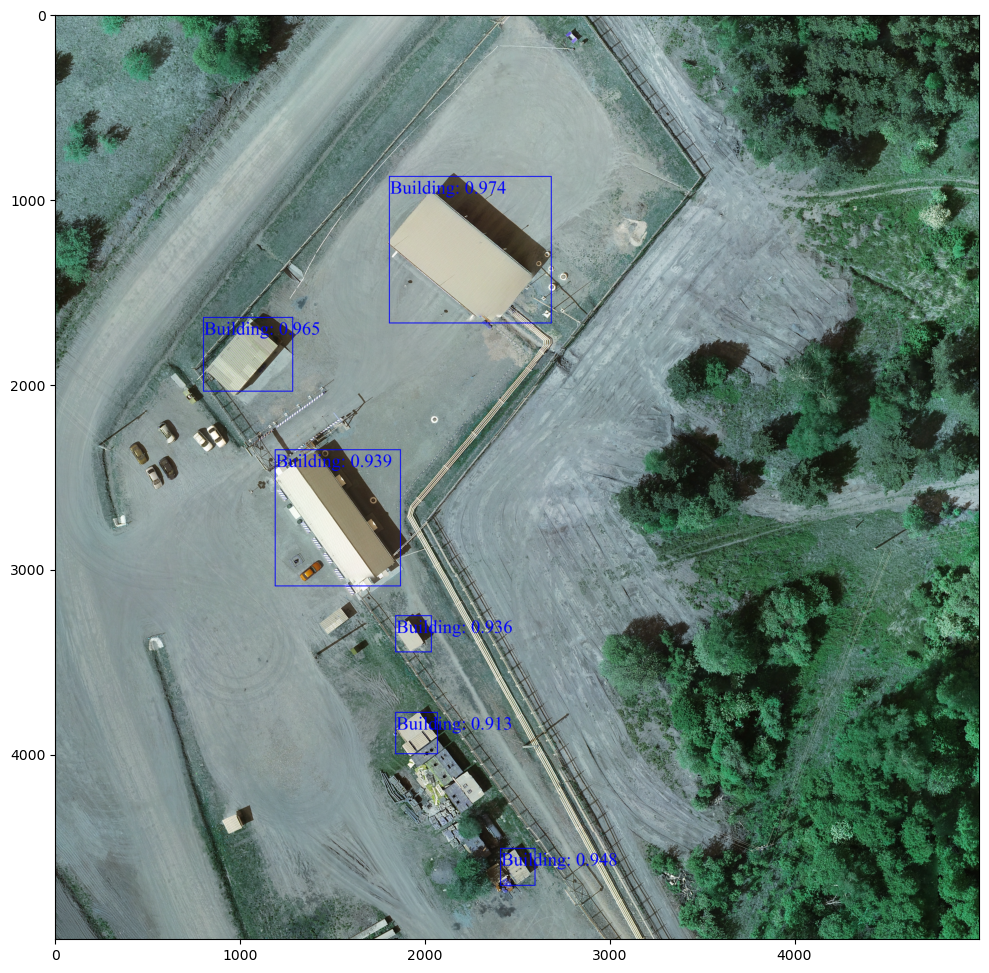

In [28]:
#image = Image.open('C:/Users/User/Desktop/Teobox_Kedrovka_2023-06-06T11.31.53/kedr-3-7.tif')

image = F.hflip(output_image.permute(1, 2, 0))

f, ax = plt.subplots(figsize=(12, 12))

ax.imshow(image)

In [59]:
metric_logger

NameError: name 'metric_logger' is not defined

In [25]:
#torch.save(model.state_dict(), 'model_weights_third.pth')